In [178]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn as dglnn
from dgl import AddSelfLoop
from dgl.data import CoraGraphDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [179]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl import DGLGraph


In [180]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata["h"] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)


In [201]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(8710, 16)
        self.layer2 = GCNLayer(16, 5)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

In [258]:
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=8710, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=5, bias=True)
  )
)


In [250]:
from GOOD.data.good_datasets.good_cora import GOODCora
import torch
import dgl 

cora_datasets, cora_meta_info = GOODCora.load("good_data/", domain='word', shift='covariate', generate=False)
dataset = cora_datasets.data

# dataset = CoraGraphDataset()


g = dgl.graph((dataset.edge_index[0], dataset.edge_index[1]))
g.ndata['feats'] = dataset.x
g.ndata['labels'] = dataset.y
g.ndata['train_mask'] = dataset.train_mask
g.ndata['val_mask'] = dataset.val_mask
g.ndata['test_mask'] = dataset.test_mask
g.ndata['id_val_mask'] = dataset.id_val_mask
g.ndata['id_test_mask'] = dataset.id_test_mask


labels_to_keep = [57, 33, 27, 7, 53]
labels_not_to_keep = list(set(range(70)) - set(labels_to_keep))
for label in labels_not_to_keep:
    label_idx = g.ndata['labels'] == label
    idxs = [i for i, x in enumerate(label_idx) if x]
    
    g = dgl.remove_nodes(g, idxs)

label_map = {
    57: 0,
    33: 1,
    27: 2,
    7: 3,
    53: 4
}

for i in range(g.num_nodes()):
    g.ndata['labels'][i] = torch.tensor(label_map[int(g.ndata['labels'][i])])
    
feats = g.ndata['feats'] 
labels = g.ndata['labels']
data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
data['labels'].value_counts()

import pandas as pd

feats = g.ndata['feats']
labels = g.ndata['labels']
data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
data.head()

,feats,labels
0,0,3
1,1,3
2,2,2
3,3,3
4,4,1


In [251]:
aflite_data = pd.read_csv("aflite_cora_full.csv")
aflite_data.head()

,Unnamed: 0,feats,labels
0,0,2,2
1,1,3,3
2,2,5,1
3,3,8,1
4,4,9,3


In [252]:
removed_nodes = torch.tensor(list(set(range(len(data))) - set(aflite_data['feats'].values)))
print(len(removed_nodes))

1565


In [253]:
# g.remove_nodes(removed_nodes)
g = dgl.remove_nodes(g, removed_nodes)

In [254]:
features = g.ndata["feats"]
labels = g.ndata["labels"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
test_mask_id = g.ndata["id_test_mask"]
print(features.shape)

torch.Size([2314, 8710])


In [255]:
sum(train_mask), sum(test_mask), sum(test_mask_id)

(tensor(988), tensor(464), tensor(224))

In [256]:

def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")


In [259]:
import time

import numpy as np

# Add edges between each node and itself to preserve old node representations
g.add_edges(g.nodes(), g.nodes())

optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []
test_acc = []
id_test_acc = []
train_loss = []
for epoch in range(50):
    if epoch >= 3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(net, g, features, labels, test_mask)
    id_acc = evaluate(net, g, features, labels, test_mask_id)
    print(
        "Epoch {:05d} | Loss {:.4f} | Test OOD Acc {:.4f} | Test ID Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, id_acc, np.mean(dur)
        )
    )
    test_acc.append(acc)
    id_test_acc.append(id_acc)
    train_loss.append(loss.item())

Epoch 00000 | Loss 1.7053 | Test OOD Acc 0.3578 | Test ID Acc 0.3795 | Time(s) nan
Epoch 00001 | Loss 2.5703 | Test OOD Acc 0.3944 | Test ID Acc 0.4732 | Time(s) nan
Epoch 00002 | Loss 7.2510 | Test OOD Acc 0.4504 | Test ID Acc 0.5446 | Time(s) nan
Epoch 00003 | Loss 4.5790 | Test OOD Acc 0.5711 | Test ID Acc 0.6116 | Time(s) 0.0830
Epoch 00004 | Loss 1.3197 | Test OOD Acc 0.6099 | Test ID Acc 0.6473 | Time(s) 0.0784
Epoch 00005 | Loss 1.3371 | Test OOD Acc 0.6293 | Test ID Acc 0.6696 | Time(s) 0.0767
Epoch 00006 | Loss 1.8683 | Test OOD Acc 0.6616 | Test ID Acc 0.7098 | Time(s) 0.0769
Epoch 00007 | Loss 1.6745 | Test OOD Acc 0.6918 | Test ID Acc 0.7321 | Time(s) 0.0772
Epoch 00008 | Loss 1.2799 | Test OOD Acc 0.7198 | Test ID Acc 0.7500 | Time(s) 0.0783
Epoch 00009 | Loss 0.9498 | Test OOD Acc 0.7349 | Test ID Acc 0.7634 | Time(s) 0.0781
Epoch 00010 | Loss 0.7204 | Test OOD Acc 0.7241 | Test ID Acc 0.7812 | Time(s) 0.0778
Epoch 00011 | Loss 0.6464 | Test OOD Acc 0.7241 | Test ID Acc 0

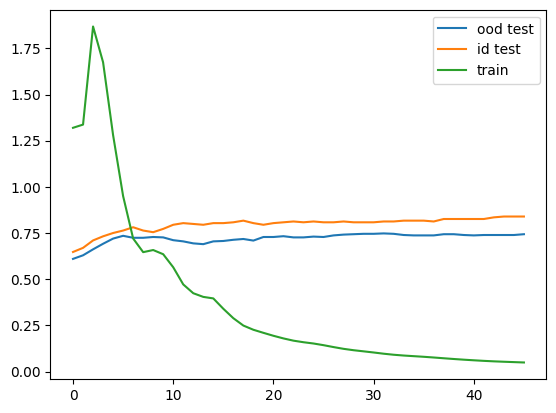

In [260]:
import matplotlib.pyplot as plt

plt.plot(test_acc[4:], label="ood test")
plt.plot(id_test_acc[4:], label="id test")
plt.plot(train_loss[4:], label="train")
plt.legend()
plt.show()

In [228]:
cora_datasets, cora_meta_info = GOODCora.load("good_data/", domain='word', shift='covariate', generate=False)
dataset = cora_datasets.data

# dataset = CoraGraphDataset()


g = dgl.graph((dataset.edge_index[0], dataset.edge_index[1]))
g.ndata['feats'] = dataset.x
g.ndata['labels'] = dataset.y
g.ndata['train_mask'] = dataset.train_mask
g.ndata['val_mask'] = dataset.val_mask
g.ndata['test_mask'] = dataset.test_mask
g.ndata['id_val_mask'] = dataset.id_val_mask
g.ndata['id_test_mask'] = dataset.id_test_mask


labels_to_keep = [57, 33, 27, 7, 53]
labels_not_to_keep = list(set(range(70)) - set(labels_to_keep))
for label in labels_not_to_keep:
    label_idx = g.ndata['labels'] == label
    idxs = [i for i, x in enumerate(label_idx) if x]
    
    g = dgl.remove_nodes(g, idxs)

label_map = {
    57: 0,
    33: 1,
    27: 2,
    7: 3,
    53: 4
}

for i in range(g.num_nodes()):
    g.ndata['labels'][i] = torch.tensor(label_map[int(g.ndata['labels'][i])])
    
feats = g.ndata['feats'] 
labels = g.ndata['labels']
data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
data['labels'].value_counts()

import pandas as pd

feats = g.ndata['feats']
labels = g.ndata['labels']
data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
data.head()

,feats,labels
0,0,3
1,1,3
2,2,2
3,3,3
4,4,1


In [229]:
features = g.ndata["feats"]
labels = g.ndata["labels"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
test_mask_id = g.ndata["id_test_mask"]
print(features.shape)

torch.Size([3879, 8710])


In [230]:
sum(train_mask), sum(test_mask), sum(test_mask_id)

(tensor(1786), tensor(587), tensor(415))

In [231]:
import time

import numpy as np

net = Net()


# Add edges between each node and itself to preserve old node representations
g.add_edges(g.nodes(), g.nodes())

optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []
test_acc = []
id_test_acc = []
train_loss = []
for epoch in range(50):
    if epoch >= 3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(net, g, features, labels, test_mask)
    id_acc = evaluate(net, g, features, labels, test_mask_id)
    print(
        "Epoch {:05d} | Loss {:.4f} | Test OOD Acc {:.4f} | Test ID Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, id_acc, np.mean(dur)
        )
    )
    test_acc.append(acc)
    id_test_acc.append(id_acc)
    train_loss.append(loss.item())

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 1.6674 | Test OOD Acc 0.2947 | Test ID Acc 0.2771 | Time(s) nan
Epoch 00001 | Loss 9.9798 | Test OOD Acc 0.4668 | Test ID Acc 0.4867 | Time(s) nan
Epoch 00002 | Loss 8.0029 | Test OOD Acc 0.4463 | Test ID Acc 0.4916 | Time(s) nan
Epoch 00003 | Loss 10.9839 | Test OOD Acc 0.6542 | Test ID Acc 0.7373 | Time(s) 0.1856
Epoch 00004 | Loss 10.6806 | Test OOD Acc 0.6780 | Test ID Acc 0.7470 | Time(s) 0.1762
Epoch 00005 | Loss 9.1898 | Test OOD Acc 0.6559 | Test ID Acc 0.6916 | Time(s) 0.1765
Epoch 00006 | Loss 6.2412 | Test OOD Acc 0.6917 | Test ID Acc 0.7711 | Time(s) 0.1768
Epoch 00007 | Loss 3.4526 | Test OOD Acc 0.6150 | Test ID Acc 0.6723 | Time(s) 0.1722
Epoch 00008 | Loss 4.9308 | Test OOD Acc 0.7223 | Test ID Acc 0.8217 | Time(s) 0.1738
Epoch 00009 | Loss 1.9603 | Test OOD Acc 0.7445 | Test ID Acc 0.8337 | Time(s) 0.1717
Epoch 00010 | Loss 1.9559 | Test OOD Acc 0.7189 | Test ID Acc 0.8169 | Time(s) 0.1731
Epoch 00011 | Loss 2.0305 | Test OOD Acc 0.7581 | Test ID Acc

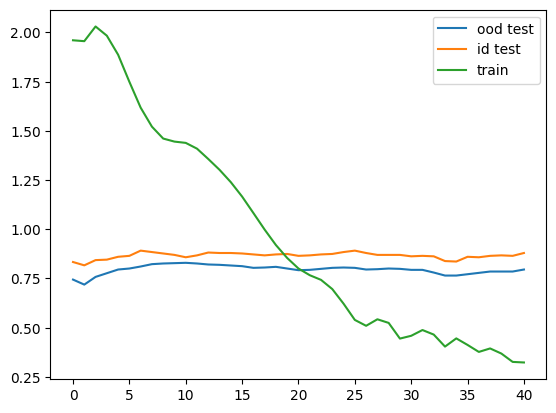

In [234]:
import matplotlib.pyplot as plt

plt.plot(test_acc[9:], label="ood test")
plt.plot(id_test_acc[9:], label="id test")
plt.plot(train_loss[9:], label="train")
plt.legend()
plt.show()

In [242]:
cora_datasets, cora_meta_info = GOODCora.load("good_data/", domain='word', shift='covariate', generate=False)
dataset = cora_datasets.data

# dataset = CoraGraphDataset()


g = dgl.graph((dataset.edge_index[0], dataset.edge_index[1]))
g.ndata['feats'] = dataset.x
g.ndata['labels'] = dataset.y
g.ndata['train_mask'] = dataset.train_mask
g.ndata['val_mask'] = dataset.val_mask
g.ndata['test_mask'] = dataset.test_mask
g.ndata['id_val_mask'] = dataset.id_val_mask
g.ndata['id_test_mask'] = dataset.id_test_mask


labels_to_keep = [57, 33, 27, 7, 53]
labels_not_to_keep = list(set(range(70)) - set(labels_to_keep))
for label in labels_not_to_keep:
    label_idx = g.ndata['labels'] == label
    idxs = [i for i, x in enumerate(label_idx) if x]
    
    g = dgl.remove_nodes(g, idxs)

label_map = {
    57: 0,
    33: 1,
    27: 2,
    7: 3,
    53: 4
}

for i in range(g.num_nodes()):
    g.ndata['labels'][i] = torch.tensor(label_map[int(g.ndata['labels'][i])])
    
feats = g.ndata['feats'] 
labels = g.ndata['labels']
data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
data['labels'].value_counts()

# import pandas as pd

# feats = g.ndata['feats']
# labels = g.ndata['labels']
# data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
# data.head()

0    928
1    855
2    783
3    663
4    650
Name: labels, dtype: int64

In [243]:
random_ids = np.random.choice(range(len(data)), len(data) - len(aflite_data), replace=False)

In [244]:
g.remove_nodes(random_ids)

In [245]:
features = g.ndata["feats"]
labels = g.ndata["labels"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
test_mask_id = g.ndata["id_test_mask"]
print(features.shape)

torch.Size([2314, 8710])


In [246]:
sum(train_mask), sum(test_mask), sum(test_mask_id)

(tensor(1083), tensor(339), tensor(241))

In [247]:
import time

import numpy as np

net = Net()

# Add edges between each node and itself to preserve old node representations
g.add_edges(g.nodes(), g.nodes())

optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []
test_acc = []
id_test_acc = []
train_loss = []
for epoch in range(50):
    if epoch >= 3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(net, g, features, labels, test_mask)
    id_acc = evaluate(net, g, features, labels, test_mask_id)
    print(
        "Epoch {:05d} | Loss {:.4f} | Test OOD Acc {:.4f} | Test ID Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, id_acc, np.mean(dur)
        )
    )
    test_acc.append(acc)
    id_test_acc.append(id_acc)
    train_loss.append(loss.item())

Epoch 00000 | Loss 1.8174 | Test OOD Acc 0.1681 | Test ID Acc 0.2116 | Time(s) nan
Epoch 00001 | Loss 5.5355 | Test OOD Acc 0.2832 | Test ID Acc 0.3278 | Time(s) nan
Epoch 00002 | Loss 3.2465 | Test OOD Acc 0.3097 | Test ID Acc 0.3485 | Time(s) nan
Epoch 00003 | Loss 2.2536 | Test OOD Acc 0.3333 | Test ID Acc 0.3402 | Time(s) 0.0831
Epoch 00004 | Loss 1.6231 | Test OOD Acc 0.3923 | Test ID Acc 0.4066 | Time(s) 0.0793
Epoch 00005 | Loss 1.3279 | Test OOD Acc 0.4484 | Test ID Acc 0.4689 | Time(s) 0.0817
Epoch 00006 | Loss 1.1833 | Test OOD Acc 0.5015 | Test ID Acc 0.5353 | Time(s) 0.0787
Epoch 00007 | Loss 1.1053 | Test OOD Acc 0.5015 | Test ID Acc 0.5228 | Time(s) 0.0774
Epoch 00008 | Loss 1.0707 | Test OOD Acc 0.5103 | Test ID Acc 0.5602 | Time(s) 0.0806
Epoch 00009 | Loss 1.0335 | Test OOD Acc 0.5015 | Test ID Acc 0.5560 | Time(s) 0.0797
Epoch 00010 | Loss 1.0160 | Test OOD Acc 0.5044 | Test ID Acc 0.5726 | Time(s) 0.0785
Epoch 00011 | Loss 0.9870 | Test OOD Acc 0.5103 | Test ID Acc 0

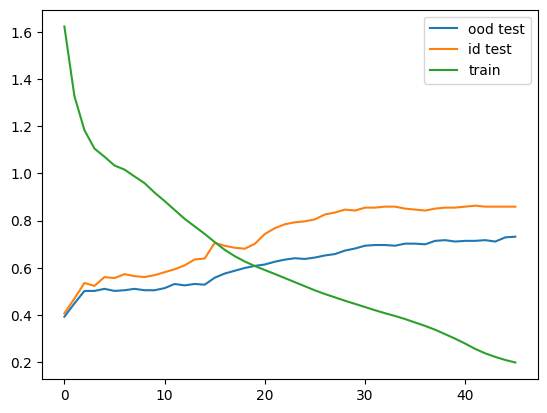

In [249]:
import matplotlib.pyplot as plt

plt.plot(test_acc[4:], label="ood test")
plt.plot(id_test_acc[4:], label="id test")
plt.plot(train_loss[4:], label="train")
plt.legend()
plt.show()